example executive summary [here](https://www.proposify.biz/blog/executive-summary)

# Executive Summary

- In Natural Language Processing, the target is for computers to correctly interpret natural language e.g. an provide meaningful interpretation. In the case of this project the power of machine learning to classify phrases and sentences will be examined.
- Objective is to :  

    1. Determine effectiveness of python models at NLP and classification of socially defined online communities  
    2. To decide if there may be a redundancy in having subreddits   


- Data is extracted from the website [Reddit.com](https://www.reddit.com). Collecting the titles from the subreddits as documents.
- Two vectorisers `CountVectorizer` and `TfidfVectorizer` are considered for the model to analyse.
- Machine Learning Classifiers (`Naive Bayes`, `Random Forest`, `Adaboost`, `VotingClassifier`, `SVM` and `Logistic Regression`) will be considered to determine if a doc belongs to either subreddit.
- Data will be split into ***train*** and **test** sample. Models are trained on the ***train*** sample and used to predict the ***test*** sample. The best model is determined by **accuracy** in predicting the ***test*** sample.


## Problem Statement

- The Goal of this project is to use python code classifiers to determine if a subreddit title belongs to "stocks" or "StockMarket"
- Find the best model given the following tools
    vectorisers: `CountVectorizer`, `TfidfVectorizer`  
    Estimators: `Naive Bayes`, `Random Forest`, `Adaboost`, `VotingClassifier`, `SVM`, `Logistic Regression`
    
## Assumptions
1. All information needed for classification resides in the title which is transformed to lower-cased words. 
2. Lemmatising and Stemming was another stepped that was avoided during this project due to the short-lived nature of the posts, this so most of the posts will be current, the presence of past tense may be useful in classifying types of posts on each side. 

_Fixed Variables_
-  vectorisers - max_features = 500, stop_words = 'english'

In [1]:
import requests
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

# Import train test split
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# Import CountVectorizer.
from sklearn.feature_extraction.text import CountVectorizer

#import confusion matrix fxn
from sklearn.metrics import confusion_matrix, plot_roc_curve, plot_confusion_matrix

## 0. Extracting data from Subreddits

In [7]:
# create a function to take subreddit and desired size of corpus
def df_subreddit(subreddit, size):
    url = 'https://api.pushshift.io/reddit/search/submission'
    df = []
    params = {
            'size': 100,
            'subreddit': subreddit
        }
    data = requests.get(url,params).json()
    df.append(pd.DataFrame(data['data']))

    for i in range((size-1)//100):
        params['before'] = min(df[-1]['created_utc'])
        data = requests.get(url,params).json()
        df.append(pd.DataFrame(data['data']))
        
    df = pd.concat(df,ignore_index=True)
    
    return df

In [8]:
# collect multiple api pulls for "stocks" subreddit
start_time = time.time()

df_stocks = df_subreddit('stocks', 500)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 16.597 seconds


In [30]:
# collect multiple api pulls for "StockMarket" subreddit
start_time = time.time()

df_stockm = df_subreddit('StockMarket', 500)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 36.815 seconds


# 1. Create DataFrame

## 1.1 Engineer target feature to turn `source_feature` into a 1/0 column, where 1 indicates `stocks` subreddit.

- combine both subreddits
- instead of managing missing data we target the 'title'. also self text is limited due to the high number of [removed] phrases implying there may have been many moderator removed posts

In [10]:
# create a combined df using UNIQUE title and if stocks = 1 StockMarket = 0
# ensure they are all unique values
d1 = {'title' : df_stocks['title'].unique(), 'stocks' : 1}
d2 = {'title' : df_stockm['title'].unique(), 'stocks' : 0}

df = pd.concat([pd.DataFrame(data=d1),pd.DataFrame(data=d2)],ignore_index=True)

In [8]:
print('Proportion of each class is printed below to ensure there is even data distribution')
print(df['stocks'].value_counts(normalize=True))

Proportion of each class is printed below to ensure there is even data distribution
1    0.500529
0    0.499471
Name: stocks, dtype: float64


In [12]:
# create csv for future use
df.to_csv('data.csv',index=False)

In [2]:
df = pd.read_csv('data.csv')

## 1.2 EDA

### 1.2.1 Word Count
There is some information about the lengt that can give away the reddit length. but for this problem we will focus on the content and see the strength of the classifiers

In [30]:
eda = df
eda['len'] = df['title'].apply(lambda x : len(x))

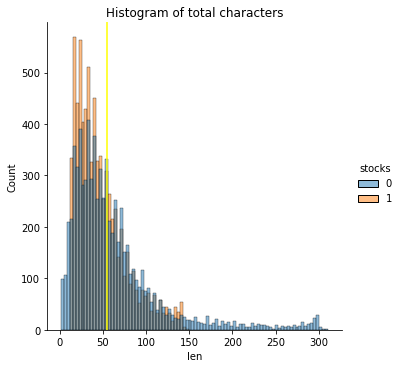

In [32]:
sns.displot(eda, x="len", hue = 'stocks')

plt.axvline(df['len'].mean(), 0,df['len'].mean(),color='yellow')
plt.title("Histogram of total characters");

### 1.2.2 Word Cloud

The words in both are quite similar so it is suspected that how the words may be strung or specific trigger words can identify differing subreddits

In [166]:
# !pip install wordcloud

In [167]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
corpus_stocks = df.loc[df['stocks']==1]['title']
corpus_stockm = df.loc[df['stocks']==0]['title']

In [38]:
sample = corpus_stocks.sample(3).values
print(sample)
len(sample[0])

['WPG bankruptcy equity.option' 'Will Beijing Supersede Hong Kong?'
 'Why are $MDLA options so cheap?']


28

In [39]:
sample = corpus_stockm.sample(3).values
print(sample)
len(sample[0])

['How to Value a Company with Multiples'
 '#aftehours 07/21 $SQBG $HSKA $EYES $FWP'
 'What app should I use for stocks']


37

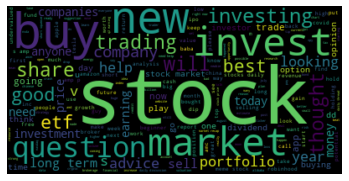

In [179]:
# Generate wordcloud for stocks subreddit
text = ' '.join(corpus_stocks.tolist()).lower()
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

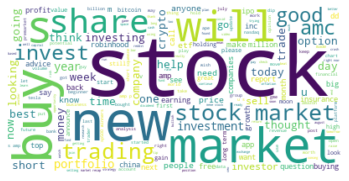

In [180]:
# Generate wordcloud for StockMarket subreddit
text = ' '.join(corpus_stockm.tolist()).lower()
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 1.2.3 Word Frequency (TOP 20 WORDS)

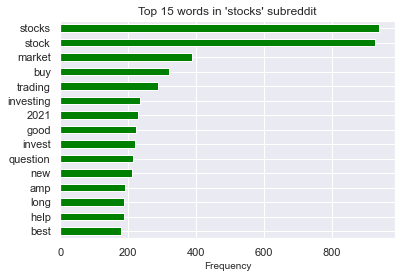

In [72]:
stocks_top_words = pd.DataFrame(cvec.fit_transform(corpus_stocks).todense(),
                          columns = cvec.get_feature_names())

fig, ax = plt.subplots()
stocks_top_words.sum().sort_values().tail(15).plot.barh(ax=ax, color='green')
ax.set_title("Top 15 words in 'stocks' subreddit")
plt.xlabel('Frequency', fontsize=10)
plt.show();

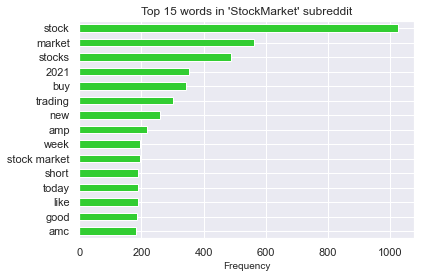

In [75]:
stockm_top_words = pd.DataFrame(cvec.fit_transform(corpus_stockm).todense(),
                          columns = cvec.get_feature_names())

fig, ax = plt.subplots()
stockm_top_words.sum().sort_values().tail(15).plot.barh(ax=ax, color='limegreen')
ax.set_title("Top 15 words in 'StockMarket' subreddit")
plt.xlabel('Frequency', fontsize=10)
plt.show();

There is very little difference in the top words, it is likely the model will have to determine the target classifications by considering the smaller frequency words

## 2. Split data into `X` and `y`

In [59]:
len(df)

15130

In [44]:
X = df[['title']]
y = df['stocks']

## 3. Split data into training and testing sets

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

## 4. Fit models Turn our text into features

In [16]:
print(f'Baseline test score: {y_train.mean():.2f}')

Baseline test score: 0.50


#### 4.0 Turn our text into features

In [217]:
# Instantiate our CountVectorizer.
cvec = CountVectorizer(max_features = 500, stop_words = 'english')
# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['title']).todense(),
                          columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['title']).todense(),
                         columns = cvec.get_feature_names())

In [19]:
results = pd.DataFrame(columns=['model','parameters','train','test'])

#### 4.1 Fit a Naive Bayes model!

In [20]:
from sklearn.naive_bayes import MultinomialNB

In [21]:
nb = MultinomialNB()
model = nb.fit(X_train_cvec, y_train)
predictions = model.predict(X_test_cvec)
model.score(X_train_cvec, y_train)

0.6330307570282894

In [22]:
new_model = pd.DataFrame([['nb',None,model.score(X_train_cvec, y_train),model.score(X_test_cvec, y_test)]],columns=results.columns.tolist())
results = results.append(new_model)

#### 4.2 Fit a Random Forest model!

In [153]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
np.random.seed(42)

In [25]:
rf = RandomForestClassifier(n_estimators=100)
et = ExtraTreesClassifier(n_estimators=100)
print(f'rf: {cross_val_score(rf, X_train_cvec, y_train, cv=5).mean()}')
print(f'ef: {cross_val_score(et, X_train_cvec, y_train, cv=5).mean()}')

rf: 0.5946073004661566
ef: 0.5862347712804065


In [26]:
rf_params = {
    'n_estimators': [20,40,100, 200],
    'max_depth': [None, 1, 5,10,20],
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs.fit(X_train_cvec, y_train)
print(gs.best_score_)
gs.best_params_

0.6013056266903273


{'max_depth': 20, 'n_estimators': 200}

In [27]:
print(gs.score(X_train_cvec, y_train))
print(gs.score(X_test_cvec, y_test))

0.6762139772627126
0.5942373777425324


In [28]:
new_model = pd.DataFrame([[gs.best_estimator_,gs.best_params_,gs.score(X_train_cvec, y_train),gs.score(X_test_cvec, y_test)]],columns=results.columns.tolist())
results = results.append(new_model)

#### 4.3 Fit a Ada boost model!

In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [32]:
# timer
start_time = time.time()

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
ada_params = {
    'n_estimators': [30,50,100],
    'base_estimator__max_depth': [1,2],
    'learning_rate': [.9, 1.]
}
gs = GridSearchCV(ada, param_grid=ada_params, cv=3)
gs.fit(X_train_cvec, y_train)

# timer
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 648.417 seconds
0.5864111897329471


{'base_estimator__max_depth': 2, 'learning_rate': 0.9, 'n_estimators': 100}

In [34]:
new_model = pd.DataFrame([[gs.best_estimator_,gs.best_params_,gs.score(X_train_cvec, y_train),gs.score(X_test_cvec, y_test)]],columns=results.columns.tolist())
results = results.append(new_model)

#### 4.4 Fit a Vote Classifier model!

In [35]:
from sklearn.ensemble import VotingClassifier

In [36]:
vote = VotingClassifier([
    ('tree', RandomForestClassifier()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))
])
vote_params = {
    'ada__n_estimators': [30,50],
    'tree__n_estimators': [50,75],
    'tree__max_depth': [1, 5],
    'voting': ['hard', 'soft']
}

# timer
start_time = time.time()

gs = GridSearchCV(vote, param_grid=vote_params, cv=3)
gs.fit(X_train_cvec, y_train)

# timer
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time/60:.1f} seconds")

Elapsed time to compute the importances: 50.9 seconds


In [38]:
new_model = pd.DataFrame([[gs.best_estimator_,gs.best_params_,gs.score(X_train_cvec, y_train),gs.score(X_test_cvec, y_test)]],columns=results.columns.tolist())
results = results.append(new_model)

In [40]:
results['vectorizer'] = 'CountVectorizer'

In [41]:
results.to_csv('./results/code1_results.csv')

## 4.x Tokenizer/Vectorizer and Hyperparameter trails

While starting with `code1` already included `GridSearch` of some models there are other models and hyperparamters are tested. `code1`,`code2`,`code3`,`code4`,`code5` iterations are based on token/vectorizer and hyperparamtetes are trailed. While you can review them in the folder all of their results will be reviewed in this notebook `code1`.

##### [code1.ipynb](code1.ipynb)
Finding testing 4 models. Tokenized and vectorized with with CountVectorizer  
- Tokenizer  
    CountVectorizer
- Model  
    4.1 Naive Bayes   
    4.2 Random Forest (GridSearch)  
    4.3 Adaboost(Decision Tree)  
    4.4 Voting Classifier (RandomForest, AdaBoost(Decision Tree))
    
*Random Forest (RF) and Voting Classifier is the best but since voting classifier has the exact test score as RF then we can assume that AdaBoost has little effect (Except where VotingClassifier train score > RF train score) * 

#### [code2.ipynb](code2.ipynb)
Comparing results if `StockMarket` subreddit is swapped for `Paleontology`  
(both using CountVectorizer)

- Tokenizer  
    CountVectorizer
- Model  
    4.1 Naive Bayes   
    4.2 Random Forest (GridSearch)  
    4.3 Voting Classifier (RandomForest, AdaBoost(Decision Tree))
    
Taking Random Forest model comparing:
- `stocks`, `StockMarket` test score is 0.594
- `stocks`, `Paleontology` test score is 0.870  

Taking Voting Classifier model comparing:
- `stocks`, `StockMarket` test score is 0.594
- `stocks`, `Paleontology` test score is 0.870  


*The types of subreddits chosen will affect the accuracy of the classifier*

#### [code3.ipynb](code3.ipynb)
Trialed TF-IDF over CountVectorizer.  
- Tokenizer  
    TfidfVectorizer
- Model  
    4.1 Naive Bayes   
    4.2 Random Forest (GridSearch)  
    4.3 Adaboost(Decision Tree)  
    4.4 Voting Classifier (RandomForest, AdaBoost(Decision Tree))
    
*Best model found to be RF. Negligible change and slight decrease in test score.*

#### [code4.ipynb](code4.ipynb)

Trialed various n-grams with RF.  
Created an iterator for ngram  
    - (1, x), where x is 1 to 9  
    - (2, x), where x is 2 to 6  
    - (3, x), where x is 3 to 6   
Collate results

- Tokenizer  
    TfidfVectorizer
- Model  
    4.1 Random Forest (max_depth=20, n_estimators=100) 
    
*ngram (1,5) appears to be the best. increasing max ngram past does improve however this may be due to collinearity
increasing min ngram does not show to improve the performance*
    
#### [code5.ipynb](code5.ipynb)
Expanded code1 trials with two more models. Tokenized and vectorized with CountVectorizer
- Tokenizer  
    CountVectorizer (unlimited tokens ~2200 << # of rows ~1600)
- Model  
    4.1 Support Vector Machines    
    4.2 Logistic Regression 
    
*LogReg is an effective model*

## 5.1 Collect all results

In [3]:
# collecting results from .csv files
overall_results = []

for report_no in [1,3,4,5]:
    overall_results.append(pd.read_csv(f'code{report_no}_results.csv'))
    
    final_results = pd.concat(overall_results,ignore_index=True).drop(columns='Unnamed: 0').sort_values(by='test',ascending=False)

In [70]:
print(f'Total models run: {len(final_results)}')
print(f'Best test accuracy: {final_results.test.max():.3f}')
print(f'Best train accuracy: {final_results.train.max():.3f}')

Total models run: 28
Best test accuracy: 0.609
Best train accuracy: 0.840


## 5.2 Best ngram

In [84]:
import re

In [116]:
bool(re.findall('\(\d, \d\)',final_results['parameters'][5]))

False

In [132]:
x=[]
y=[]
for para, test in zip(final_results['parameters'],final_results['test']):
    if bool(re.findall('\(\d, \d\)',str(para))):
        x.append(re.findall('\(\d, \d\)',para)[0])
        y.append(test)

        
ngram_scores = pd.DataFrame(data={'ngram':x,'accuracy':y}).sort_values(by='ngram')

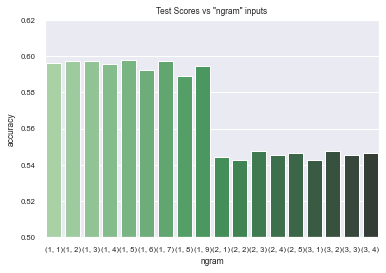

In [141]:
sns.set_theme(style="whitegrid")
sns.set(font_scale = .7)
plt.ylim(.5,.62)

sns.barplot(x=ngram_scores.ngram,y=ngram_scores.accuracy,palette=sns.color_palette("Greens_d", len(y))).set(title='Test Scores vs "ngram" inputs');

## 5.3 Best Tokenizer/Vectorizer

In [46]:
# Instantiate our CountVectorizer.
cvec = CountVectorizer(stop_words = 'english',ngram_range=(1,5),max_features=3000)
# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['title']).todense(),
                          columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['title']).todense(),
                         columns = cvec.get_feature_names())

In [12]:
X_train_cvec.filter(regex='\s').sum().sort_values().tail(20)

market crash           32
daily thread           32
year old               32
make money             33
technical analysis     34
q2 earnings            34
wall street            34
stocks buy             34
short term             36
sp500 winners          39
need help              41
meme stocks            49
recap today            54
market recap today     54
market recap           56
stocks daily           59
amp 500                62
short squeeze          68
long term             150
stock market          212
dtype: int64

In [14]:
len([x for x in X_train_cvec.columns if len(x.split())>2])

185

Delimiting the # of `max_features` improved the performeance of LogReg, while it was 500 for previous models we use 3000 because an unlimited `max_features` will create more features than available data.

## 5.4 Best Estimator  
the best model is as follows:  
- model                                                        lr
- parameters    {'Cs': 10, 'class_weight': None, 'cv': 5, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'refit': True, 'scoring': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0}
- train                                                  0.710144
- test                                                   0.609305
- vectorizer                                      CountVectorizer
    

In [31]:
# simplify the model names for easy reference when plotting
def rename_models(m):
    if 'VotingClassifier(' in m:
        return 'Vote'
    elif 'AdaBoostClassifier(' in m:
        return 'AdaBoost'
    elif 'nb' in m:
        return 'NB'
    elif 'DecisionTreeClassifier(' in m:
        return 'DT'
    elif 'RandomForestClassifier(' in m:
        return 'RF'
    elif 'lr' in m:
        return 'LogReg'
    elif 'svm' in m:
        return 'SVM'
    else:
        return m
    

final_results['estimator'] = final_results.model.apply(lambda x :rename_models(x))

In [59]:
# plotting the best test scores for each estimator
models = pd.DataFrame(final_results.groupby('estimator').max().sort_values(by='test',ascending=False))
y = models['test']
x = models.index

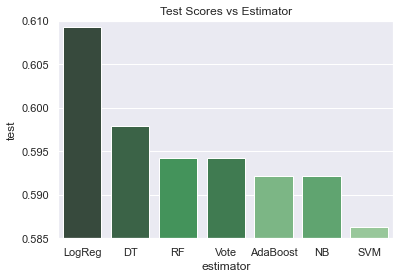

In [61]:
# plot the performance of each test vs others
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1)
pal = sns.color_palette("Greens_d", len(y))
rank = y.argsort().argsort()  # http://stackoverflow.com/a/6266510/1628638
plt.ylim(.585,.61)

sns.barplot(x=x,y=y, palette=np.array(pal)[rank]).set(title='Test Scores vs Estimator');

Although LogReg shows to be the best model, it is not fairly compared because the model used in the above graph is the only one with unlimited features in the CountVectoriser(). On the other hand other estimators like RF and VotingClassifier(Vote) use GridSearchCV and providing such simulations with an expanded feature set will be computationally exhausting.

Nonetheless LogReg will be used with following advantages:
1. Has presently the best run ***test*** scores
2. Can process large feature sets quickly
3. Has interpretable coefficients

Disadvantages:
1. May be overfit
2. Does not include feature subset selection
3. May not be able to express non-linear relationships in the features (however they may be addressed by the method of tokenisation)
4. Assumes linear boundaries in the count of the words (e.g. may miss out if `stocks` use the word YOLO only 4-6 time otherwise it belongs to `StockMarket`)

In [62]:
# finding the best model
models.loc['LogReg']

model                                                        lr
parameters    {'Cs': 10, 'class_weight': None, 'cv': 5, 'dua...
train                                                  0.710144
test                                                   0.609305
vectorizer                                      CountVectorizer
Name: LogReg, dtype: object

## 5.5 Combine Best Tokenizer/Vectorizer, ngram and Estimator

### 5.5.1 CountVectorizer and Logistic Regression
Tokenizer/Vecotrizer: CountVectorizer(stop_words = 'english',ngram_range=(1,5),max_features=3000)  
Estimator: LogisticRegressionCV(cv=5, random_state=42,max_iter=200,n_jobs=-1)

In [26]:
from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV(cv=5, random_state=42,max_iter=200,n_jobs=-1)
lr.fit(X_train_cvec, y_train)

LogisticRegressionCV(cv=5, max_iter=200, n_jobs=-1, random_state=42)

In [27]:
lr.score(X_test_cvec, y_test)

0.6132698916204071

In [41]:
from joblib import dump, load

In [ ]:
# save best model
dump(lr, 'best_model.joblib')

In [47]:
# load
lr1 = load('best_model.joblib')
lr1.score(X_test_cvec, y_test)

0.6132698916204071

### 5.5.2 Scoring the best model

In [54]:
predictions = lr.predict(X_test_cvec)
print(confusion_matrix(y_test, predictions).T)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("True Negatives:\t%s" % tn)
print("False Positives:\t%s" % fp)
print("False Negatives:\t%s" % fn)
print("True Positives:\t%s" % tp)

[[1062  636]
 [ 827 1258]]
True Negatives:	1062
False Positives:	827
False Negatives:	636
True Positives:	1258


In [45]:
print(f'Accuracy\t{(tp+tn)/(tp+tn+fp+fn)*100:.1f}')
print(f'Sensitivity\t{tp/(tp+fn)*100:.1f}')
print(f'Specificity\t{tn/(tn+fp)*100:.1f}')

Accuracy	61.3
Sensitivity	66.4
Specificity	56.2


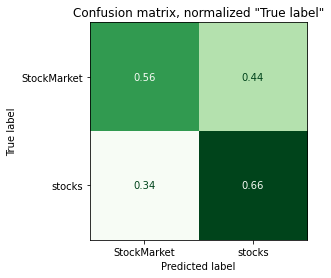

In [58]:
plot_confusion_matrix(lr1, X_test_cvec, y_test, cmap='Greens', colorbar=False
                      , normalize='true', display_labels=['StockMarket', 'stocks'])
plt.title('Confusion matrix, normalized "True label"' );

In [ ]:
The countVectoriser 

# 6. Visualisations

## 6.0 Subreddit
choice of subreddit matters, as seen here even though `stocks-Stockmarket` is used in final analysis. A categorical dissimmilar topic like `Paleontology` is a lot easier for a model to differentiate

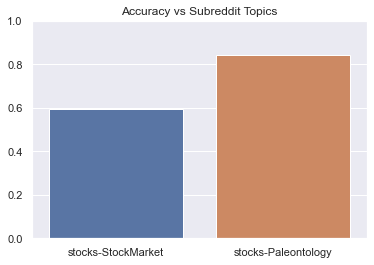

In [53]:
# plot the performance of each test vs others
y = [0.594237,0.843284]
x = ['stocks-StockMarket','stocks-Paleontology']

sns.set_theme(style="whitegrid")
sns.set(font_scale = 1)
plt.ylim(0,1)

sns.barplot(x=x,y=y).set(title='Accuracy vs Subreddit Topics');

## 6.1 Best Model - Visualisations (Logistic Regression)

### 6.1.1 Best Model - AUC

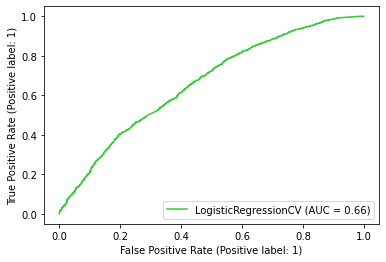

In [69]:
lr_roc = plot_roc_curve(lr1, X_test_cvec, y_test,color='limegreen');

### 6.1.2 Best Model - Feature Importance

In [93]:
best_coef = pd.DataFrame(data={'feature':X_train_cvec.columns.to_list(),'coef':lr1.coef_[0].tolist()})
top_coef = best_coef.sort_values(by='coef',ascending=False).head(10)
bot_coef = best_coef.sort_values(by='coef',ascending=False).tail(10)

In [94]:
top_coef['odds'] = top_coef['coef'].apply(lambda x: np.exp(x))
top_coef

,feature,coef,odds
2521,stocks,0.566208,1.761574
2094,question,0.557480,1.746266
192,advice,0.532588,1.703335
2859,vs,0.442899,1.557215
965,etf,0.393231,1.481760
2662,thoughts,0.357615,1.429916
355,baba,0.356485,1.428300
2525,stocks daily,0.329221,1.389885
966,etfs,0.295664,1.344018
1851,nvda,0.272379,1.313084


In [95]:
bot_coef['odds'] = bot_coef['coef'].apply(lambda x: np.exp(x))
bot_coef

,feature,coef,odds
860,doing,-0.390592,0.676656
2222,review,-0.393063,0.674986
2917,week,-0.400912,0.669709
1157,game,-0.443185,0.641989
477,buffett,-0.446706,0.639732
2505,stock market,-0.450394,0.637377
1721,million,-0.472733,0.623297
238,amc,-0.558386,0.572132
1385,insurance,-0.599142,0.549283
717,crypto,-0.606036,0.545509


In [96]:
coef_word = top_coef.feature.to_list()[1]
coef_stocks = top_coef.odds.to_list()[1]
print(f'Every word "{coef_word}" in a subreddit title is {coef_stocks:.2f} times as likely to be considered from `stocks` subreddit')

Every word "question" in a subreddit title is 1.75 times as likely to be considered from `stocks` subreddit


In [101]:
df[df.title.str.contains('question')]['stocks'].value_counts()

1    127
0     59
Name: stocks, dtype: int64

In [98]:
.683/(1-.683)

2.154574132492114

In [86]:
coef_word = bot_coef.feature.to_list()[-1]
coef_stocks = bot_coef.odds.to_list()[-1]
print(f'Every word "{coef_word}" in a subreddit title is {coef_stocks:.2f} times as likely to be considered from `stocks` subreddit.\n This word is more likely from `StockMarket`')

Every word "crypto" in a subreddit title is 0.55 times as likely to be considered from `stocks` subreddit.
 This word is more likely from `StockMarket`


## 6.2 Random Forest

In [149]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [83]:
# use the best RF model to find some important words or phrases
models.loc['RF']

model         RandomForestClassifier(max_depth=20, n_estimat...
parameters               {'max_depth': 20, 'n_estimators': 200}
train                                                  0.682383
test                                                   0.594237
vectorizer                                      TfidfVectorizer
Name: RF, dtype: object

In [154]:
rf1 = RandomForestClassifier(max_depth= 20, n_estimators= 200)
rf1.fit(X_train_cvec,y_train)

array([3.28880952e-03, 9.51132721e-03, 1.04444631e-03, 1.46366087e-03,
       8.94443449e-04, 1.69587563e-03, 7.70914746e-04, 8.87021891e-04,
       7.41263568e-04, 1.65340365e-03, 7.81050797e-04, 4.53540338e-04,
       1.58834922e-03, 1.31565057e-03, 4.15826540e-04, 2.07168128e-02,
       1.51922791e-03, 1.45605581e-03, 3.81976963e-03, 6.49805265e-04,
       1.17243046e-03, 6.97546731e-04, 1.18553124e-03, 1.41522968e-03,
       7.58701489e-04, 7.06961256e-04, 9.88176574e-04, 1.20377062e-03,
       6.29985377e-04, 2.32756488e-02, 2.79985421e-03, 7.47664987e-04,
       6.39681095e-04, 1.43850065e-03, 9.25440456e-04, 2.18736417e-02,
       1.05666882e-03, 3.62969553e-04, 4.36605994e-03, 2.87303145e-04,
       1.00932149e-03, 5.51534583e-03, 4.22406967e-04, 5.26669187e-03,
       2.93645541e-03, 1.88730459e-03, 8.13285928e-04, 3.87033237e-04,
       1.36640505e-03, 2.34222595e-03, 2.42356905e-03, 7.85457657e-04,
       3.57315827e-03, 5.49514586e-04, 1.19853704e-03, 1.01656458e-03,
      

In [161]:
forest_importances = pd.Series(rf1.feature_importances_, index=X_train_cvec.columns)
forest_import_20_top = forest_importances.sort_values(key=lambda x: abs(x)).tail(20)
forest_import_20_bot = forest_importances.sort_values().head(20)

### 6.2.1 Random Forest Most Important Words

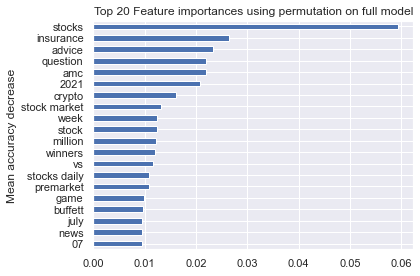

In [164]:
fig, ax = plt.subplots()
forest_import_20_top.plot.barh(ax=ax)
ax.set_title("Top 20 Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### 6.2.2 Random Forest Least Important Words

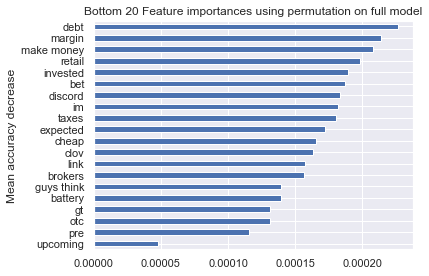

In [181]:
fig, ax = plt.subplots()
forest_import_20_bot.plot.barh(ax=ax)
ax.set_title("Bottom 20 Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### 6.2.3 DECISION TREE, TREE VIZ

In [186]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

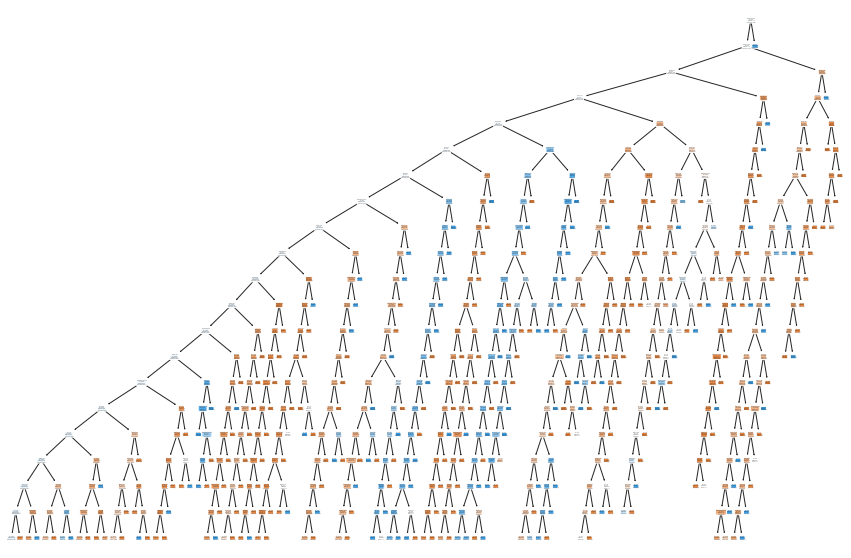

In [191]:
fig = plt.figure(figsize=(15, 10))
plot_tree(rf1.estimators_[0], 
          feature_names=X_train_cvec.columns,
          filled=True, impurity=True, 
          rounded=True);

# Conclusions 

The model with based on trials of: 

- Tokenizer/Vecotrizer: `CountVectorizer`, `TfidfVectorizer`  
- Estimators: `Naive Bayes`, `Random Forest`, `Adaboost`, `VotingClassifier`, `SVM`, `Logistic Regression`

The model with the best performance is: 
- CountVectorizer(stop_words = 'english',ngram_range=(1,5),max_features=3000)  
- Estimator: LogisticRegressionCV(cv=5,  random_state=42, max_iter=200,n_jobs=-1)

**Baseline accuracy is 0.5 and best model test score is 0.61 with 22.6% improvement.**

Objectives:
    1. Determine effectiveness of python models at NLP and classification of socially defined online communities  
    2. To decide if there may be a redundancy in having subreddits

**There is significant score improvement to the baseline of the model therefore the model can be useful to distinguish a subreddit however the error rate is still 39%. There appears to be a high amount of overlap in the topics and so the models find it hard to distinguish. However the content in the title may not be sufficient to prove that the groups are distinct. Other aspects such as media and length of selftext should be relevant but were not available due to the API restrictions.**

# Recommendations
1. EDA and project scores allude that high `max_feature` contributing to favourable scores because of the inclusion of more rare words (where `stocks` and `StockMarket` share many similar words).  Towards the end of the project, the `max_feature` hyperparameter appears to be very significant because as it was unlimited during the initial Logistic Regression fit there was an improvement in scores. Due to time constraints there was no further investigation on the relationship between `max_feature` and score. Further work may be done to try an expanded feature set against decision tree classifiers.

2. Although Stemming and Lemmatising was avoided for this analysis. It may be helpful to the model to allow for a more generalised regression. Also be able to consolidate words and reduce the need for so many features.

3. Further work can be done to compare the model Accuracy, Sensitivity and Specificity against human classifications in a blind test. Trails can be performed with the model and human trained or read the same number of articles and compare the scores. Additionally the current best model trained against a large sample can be used to see how the former scores differ.

---